# Example script to load OpenUCS data and format is as a DSS dataset

In [23]:
import xarray as xr
import numpy as np

import matplotlib.pyplot as plt
import xrft

In [24]:
dt = np.dtype([('re', np.int16), ('im', np.int16)])

channels = 2
sources = 1
L = 1024
measurements = 3
start_time = 5
F = 813

In [25]:
data = []

t = []

for src in range(sources):

	ch_data = []

	for ch in range(channels):

		ms_data = []
		ms_t = []

		for ms in range(measurements):

			a = np.fromfile(f'rx_ch{ch}_{ms}.dat', dtype=dt)
			

			b = np.zeros(len(a), dtype=np.complex64)
			b[:].real = a['re']/(2**15)
			b[:].imag = a['im']/(2**15)

			y = np.split(b, len(b)//L)

			num_sequences = len(b)//L

			# start time is ms sec.
			# each sequence has a duration of 0.1s
			ms_t.extend([ms +_t*0.1 for _t in range(num_sequences)])

			ms_data.extend(y)
			
		t = ms_t
		ch_data.append(ms_data)


	data.append(ch_data)

t = np.asarray(t)
data = np.asarray(data)


In [26]:
#dimensions = ["x", "y", "z", "t", "source", "channels", "data"]
dimensions = ["source", "channel", "t", "data"]

coords = dict(
	start_time=start_time,
    t=(("t", t))
)

# attrs=dict(
# 	position_unit="m",
# 	position_type="relative"
# )

da = xr.DataArray(data, dims=dimensions, coords=coords)
da.coords

Coordinates:
    start_time  int64 5
  * t           (t) float64 0.0 0.1 0.2 0.3 0.4 0.5 ... 1.9 2.0 2.1 2.2 2.3 2.4

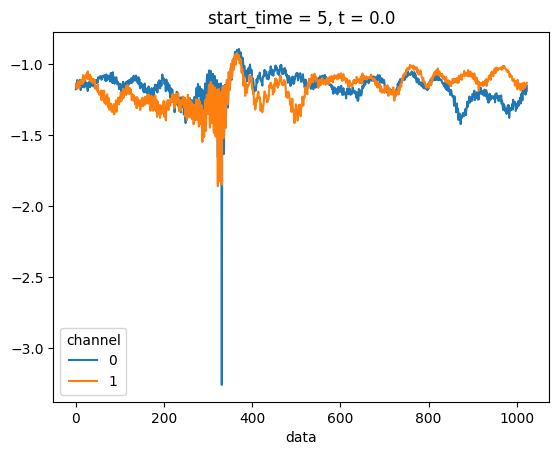

In [27]:
20*np.log10(abs(da.isel(source=0, t=0))).plot(x="data", hue="channel"); # semicolon to supress output of plot()

In [28]:
# example usage
def zch(u, Nzc, q=0, dtype=np.complex64):
	n = np.arange(Nzc)
	cf = np.mod(Nzc, 2)
	return np.exp(-1j * np.pi * u * n * (n + cf + 2*q)/Nzc, dtype=dtype)


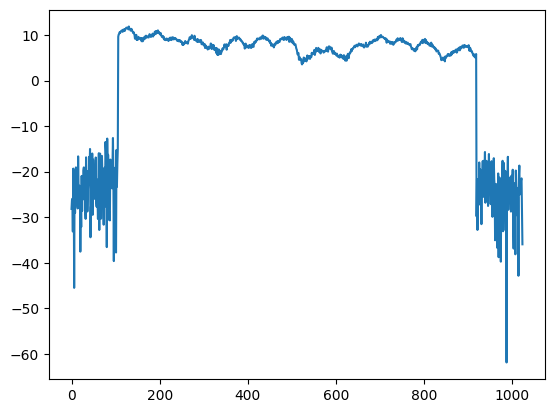

In [29]:
# from time to frequency
da_fft = xrft.fft(da, dim='data', shift=True)
plt.plot(20*np.log10(abs(da_fft.isel(source=0, channel=0, t=0))));


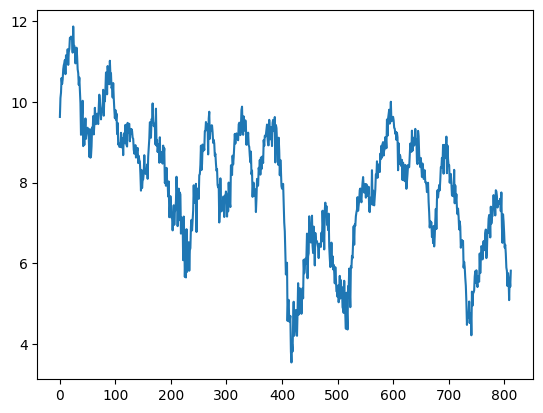

In [30]:
# slice to only have the ZC sequence
da_fft = da_fft.isel(freq_data=slice((L-F)//2+1, (L-F)//2 + F+1))

plt.figure()
plt.plot(20*np.log10(abs(da_fft.isel(source=0, channel=0, t=0))));


813


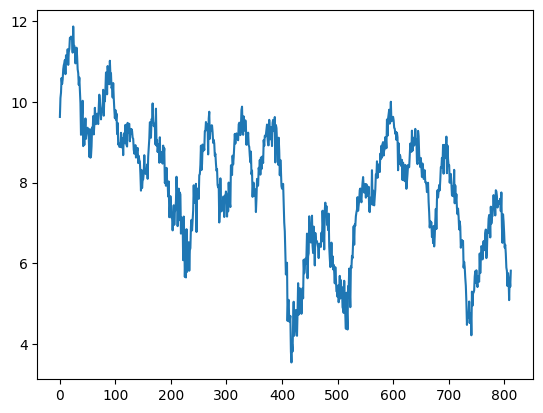

In [31]:
# time
xzch = zch(1, F)

xzch = xr.DataArray(xzch, dims="freq_data")  # create dimension so XR knows along which dimension to operate

print(xzch.sizes["freq_data"])

da_fft = da_fft / xzch

plt.plot(20*np.log10(abs(da_fft.isel(source=0, channel=0, t=0))));

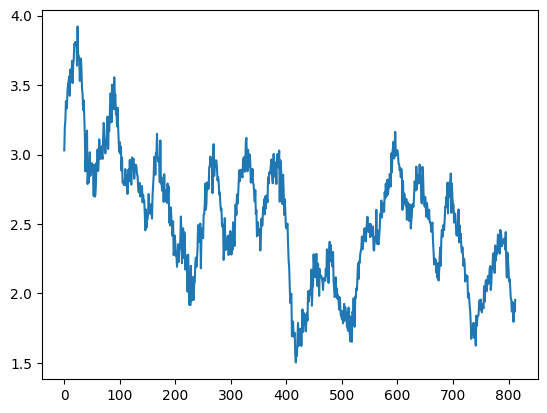

In [32]:
plt.plot(abs(da_fft.isel(source=0, channel=0, t=0)));

/home/gilles/venv/lib/python3.11/site-packages/xrft/xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)


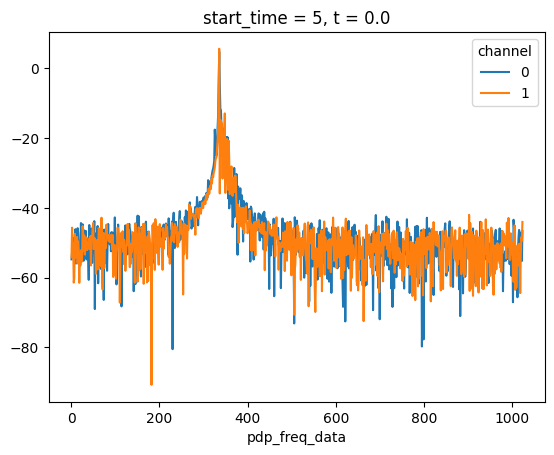

In [33]:
y = xrft.ifft(da_fft, dim='freq_data', prefix="pdp_")

y = 20*np.log10(abs(y.isel(source=0, t=0)))

y.plot(hue="channel");